<a href="https://colab.research.google.com/github/Davo00/INLTP-Assignments/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
October 30, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

## Group Names
- Simon Pavicic
- Davit Melkonyan
- Leon Remke
- Max Ludwig

# **Assignment 1: “Word Embeddings and Probabilistic Language Models”**
**Due**: Monday, November 13, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: F.R.I.E.N.D.S and  Word2Vec (Grade (2 + 2 + 4) = 8)**

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

### Subtask 1: Pre-processing
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that  determines which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains a line from the movie and the `author` is the one who said it. Since these are the only two columns we need, we remove the rest and only keep these two columns.

In [ ]:
import re
import pandas as pd
from collections import defaultdict
import spacy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
FRIENDS_PATH = "friends_quotes.csv"

df = pd.read_csv(FRIENDS_PATH)
print(f"Shape of data before filtering: {df.shape}")

# Drop rows with any null values
df = df.dropna()

# Replace empty strings with NaN and then drop those rows
df = df.replace('', float('nan')).dropna()

# Reset the index after dropping rows
df = df.reset_index(drop=True)
print(f"Shape of data after filtering: {df.shape}")

df.head(10)

Shape of data before filtering: (60291, 6)
Shape of data after filtering: (60291, 6)


,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
5,Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax. This is not even a date...",5.0,1.0
6,Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
7,Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back in high school, I'm stand...",7.0,1.0
8,All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
9,Chandler,1.0,Monica Gets A Roommate,"Then I look down, and I realize there's a phon...",9.0,1.0


Fortunately, there is no missing data, so we do not need to worry about that.

In [ ]:
df.isnull().sum() # check for missing data

author            0
episode_number    0
episode_title     0
quote             0
quote_order       0
season            0
dtype: int64

Use SpaCy to preprocess the text. For this, perform the following steps:
- lowercase the words
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits.
- remove lines that have less than 4 words, since they cannot contribute much to the training process.

Please do not add any additional steps on your own or additional cleaning as we want to achieve comparable results.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(f"Stopwords: {stopwords}")

regex = re.compile('[^a-z0-9]') # need only lower case since executed after lower in for loop
quotes = []  # to save all the lines
for quote in list(nlp.pipe(df["quote"].values)):
    # iterate over tokens in quote
    preprocessed_quote = []
    for token in quote:
        preprocessed_token = token.lower_ # lowercase word
        if preprocessed_token not in stopwords: # remove stopwords
            preprocessed_token = regex.sub(" ", preprocessed_token) # replace non-alphabetic characters with space

            # remove the space if at the beginning or at the end
            if preprocessed_token[0] == " ":
                preprocessed_token = preprocessed_token[1:]
            if len(preprocessed_token) > 0 and preprocessed_token[-1] == " ":
                preprocessed_token = preprocessed_token[:-1]

            # remove single characters
            if len(preprocessed_token) > 1:
                preprocessed_quote.append(preprocessed_token)
    # remove lines with less than 3 words
    if len(preprocessed_quote) >= 4:
        quotes.append(preprocessed_quote)

print(quotes[:10])

Stopwords: {'yourself', 'last', "'s", 'until', 'even', 'whence', 'most', 'can', 'during', 'back', 'wherein', 'did', 'hers', 'we', 'not', 'someone', 'really', 'neither', 'hence', 'hereupon', 'will', 'since', 'otherwise', 'noone', 'ourselves', 'already', 'beyond', 'though', 'where', 'he', 'a', 'eleven', 'thereafter', 'sometimes', 'forty', 'anywhere', 'always', 'but', 'one', 'perhaps', 'all', 'towards', 'bottom', 'it', 'off', 'see', 'without', '‘ll', 'cannot', 'latterly', 'here', 'once', 'call', 'name', 'full', 'often', 'nowhere', 'becoming', 'does', 'both', 'meanwhile', 'thru', 'and', 'is', 'make', 'do', 'hundred', '‘m', 'that', 'myself', 'she', 'more', 'doing', 'sixty', "'ve", 'as', 'using', 'which', 'about', 'indeed', 'being', 'due', 'mostly', 'several', 'are', 'former', 'if', 'ca', '’d', 'again', 'herein', 'made', 'elsewhere', 'whose', 'almost', '’ll', 'therein', 'whatever', 'four', 'only', 'after', 'enough', 'many', 'at', 'no', 'be', 'twelve', 'thence', 'of', 'the', 'further', 'have'

/Users/leonremke/miniconda3/envs/bomberman/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


[['c m', 'going', 'guy', 'got', 'ta', 'wrong'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['cause', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'and', 'having', 'sex'], ['alright', 'high', 'school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked'], ['sudden', 'phone', 'starts', 'ring', 'know', 'everybody', 'starts', 'looking'], ['finally', 'figure', 'better', 'answer', 'turns', 'mother', 'weird', 'because', 'calls'], ['guy', 'says', 'hello', 'wanna', 'kill'], ['feel', 'like', 'reached', 'throat', 'grabbed', 'small', 'intestine', 'pulled', 'mouth', 'tied', 'neck'], ['explaining', 'carol', 'moved', 'stuff', 'today']]


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, in order to keep the computation time-limited and to choose the most important words.

In [ ]:
from gensim.models.phrases import Phrases, Phraser

# list of all words #
words = list(set([word for quote in quotes for word in quote]))
print(f"Number of all words: {len(words)}\n")

bigram = Phrases(quotes, min_count=10) # define the phraser for bi-gram creation
bigram_phraser = Phraser(bigram)
new_lines = [bigram_phraser[quote] for quote in quotes]  # transform the lines #
new_lines[:10]

INFO - 17:33:17: collecting all words and their counts
INFO - 17:33:17: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:33:17: PROGRESS: at sentence #10000, processed 84535 words and 64068 word types
INFO - 17:33:17: PROGRESS: at sentence #20000, processed 171141 words and 112647 word types
INFO - 17:33:17: PROGRESS: at sentence #30000, processed 256195 words and 157322 word types
INFO - 17:33:17: collected 160684 token types (unigram + bigrams) from a corpus of 262770 words and 30822 sentences
INFO - 17:33:17: merged Phrases<160684 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 17:33:17: Phrases lifecycle event {'msg': 'built Phrases<160684 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.11s', 'datetime': '2023-11-11T17:33:17.777225', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.1-arm64-arm-64bit', 'event': 'created'}
INFO - 17:33:17: exporting phrases from Phr

Number of all words: 16593



INFO - 17:33:17: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<203 phrases, min_count=10, threshold=10.0> from Phrases<160684 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.10s', 'datetime': '2023-11-11T17:33:17.882046', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.1-arm64-arm-64bit', 'event': 'created'}


[['c m', 'going', 'guy', 'got_ta', 'wrong'],
 ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'],
 ['cause', 'want', 'went', 'carl', 'oh'],
 ['okay',
  'everybody',
  'relax',
  'date',
  'people',
  'going',
  'dinner',
  'and',
  'having_sex'],
 ['alright',
  'high_school',
  'standing',
  'middle',
  'cafeteria',
  'realize',
  'totally',
  'naked'],
 ['sudden',
  'phone',
  'starts',
  'ring',
  'know',
  'everybody',
  'starts',
  'looking'],
 ['finally',
  'figure',
  'better',
  'answer',
  'turns',
  'mother',
  'weird',
  'because',
  'calls'],
 ['guy', 'says', 'hello', 'wanna', 'kill'],
 ['feel_like',
  'reached',
  'throat',
  'grabbed',
  'small',
  'intestine',
  'pulled',
  'mouth',
  'tied',
  'neck'],
 ['explaining', 'carol', 'moved', 'stuff', 'today']]

In [ ]:
from collections import Counter

### find the top 15.000 words for the vocabulary###
all_words_bigrams = [word for line in new_lines for word in line]
words_bigram_counter = Counter(all_words_bigrams)
vocab = [word_counter_tupel[0] for word_counter_tupel in words_bigram_counter.most_common(15000)] ### top 15000 words

# remove all words from the line that are not in top 15000 words
new_lines_top_vocab = []
for line in new_lines:
    new_lines_top_vocab.append([])
    for word in line:
        if word in vocab:
            new_lines_top_vocab[-1].append(word)
    if len(new_lines_top_vocab[-1]) == 0: # remove empty lines if all words were not in top 15000
        new_lines_top_vocab.pop(-1)
print(new_lines_top_vocab[:10])

[['c m', 'going', 'guy', 'got_ta', 'wrong'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['cause', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'and', 'having_sex'], ['alright', 'high_school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked'], ['sudden', 'phone', 'starts', 'ring', 'know', 'everybody', 'starts', 'looking'], ['finally', 'figure', 'better', 'answer', 'turns', 'mother', 'weird', 'because', 'calls'], ['guy', 'says', 'hello', 'wanna', 'kill'], ['feel_like', 'reached', 'throat', 'grabbed', 'small', 'intestine', 'pulled', 'mouth', 'tied', 'neck'], ['explaining', 'carol', 'moved', 'stuff', 'today']]


In [ ]:
word_freq = dict(words_bigram_counter)

In [ ]:
word_freq['central_perk']

36

In [ ]:
word_freq['joey']

1883

### Subtask 2: Training the Model


Use the Gensim implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters; define your parameters in such a way that the following conditions are satisfied:
 - ignore all words that have a total frequency of less than 2.
 - dimensions of the embeddings: 100
 - initial learning rate (step size) of 0.03
 - 20 negative samples
 - window size 3
 - the learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [ ]:
from gensim.models import Word2Vec
def hash(astring):
    return ord(astring[0])

In [ ]:
w2v = Word2Vec(
    min_count=2,
    window=3,
    vector_size=100,
    sample=6e-5,
    alpha=0.03,
    min_alpha=0.0001,
    negative=20,
    hashfxn=hash,
    workers=1
)

INFO - 17:33:20: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2023-11-11T17:33:20.197561', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.1-arm64-arm-64bit', 'event': 'created'}


2) Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
Use the `build_vocab` function to process the data. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus.

In [ ]:
# I had to use lines, otherwise the words joey and central_perk were not in the top 15000 words
w2v.build_vocab(corpus_iterable=new_lines_top_vocab, progress_per=10000)

INFO - 17:33:20: collecting all words and their counts
INFO - 17:33:20: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:33:20: PROGRESS: at sentence #10000, processed 81112 words, keeping 9621 word types
INFO - 17:33:20: PROGRESS: at sentence #20000, processed 164131 words, keeping 13290 word types
INFO - 17:33:20: PROGRESS: at sentence #30000, processed 244255 words, keeping 14970 word types
INFO - 17:33:20: collected 15000 word types from a corpus of 250337 raw words and 30822 sentences
INFO - 17:33:20: Creating a fresh vocabulary
INFO - 17:33:20: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9202 unique words (61.35% of original 15000, drops 5798)', 'datetime': '2023-11-11T17:33:20.237487', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.1-arm64-arm-64bit', 'event': 'prepare_vocab'}
INFO - 17:33:20: Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 244539 word corpus

3) Finally, we  train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis.

In [ ]:
w2v.train(corpus_iterable=new_lines_top_vocab, total_examples=w2v.corpus_count, epochs=100, report_delay=1)
# w2v.init_sims(replace=True) No longer required for efficiency

INFO - 17:33:20: Word2Vec lifecycle event {'msg': 'training model with 1 workers on 9202 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2023-11-11T17:33:20.290504', 'gensim': '4.3.2', 'python': '3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]', 'platform': 'macOS-14.1-arm64-arm-64bit', 'event': 'train'}
INFO - 17:33:20: EPOCH 0: training on 250337 raw words (115398 effective words) took 0.3s, 336869 effective words/s
INFO - 17:33:20: EPOCH 1: training on 250337 raw words (115469 effective words) took 0.3s, 360014 effective words/s
INFO - 17:33:21: EPOCH 2: training on 250337 raw words (115307 effective words) took 0.3s, 368000 effective words/s
INFO - 17:33:21: EPOCH 3: training on 250337 raw words (115221 effective words) took 0.3s, 380198 effective words/s
INFO - 17:33:21: EPOCH 4: training on 250337 raw words (115098 effective words) took 0.3s, 383316 effective words/s
INFO - 17:33:22: EPOCH 5: training on 25033

(11525377, 25033700)

### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset:

We look for the most similar words to the name of the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



In [ ]:
w2v.wv.most_similar(positive=["central_perk"])

[('back', 0.7201736569404602),
 ('conan', 0.616219699382782),
 ('sitting_couch', 0.4656095802783966),
 ('ish', 0.45086634159088135),
 ('cuddling', 0.44639337062835693),
 ('intrigued', 0.43748244643211365),
 ('crossword', 0.42760711908340454),
 ('crash', 0.42212584614753723),
 ('appartment', 0.41930893063545227),
 ('shhh', 0.41291123628616333)]

In [ ]:
w2v.wv.most_similar(positive=["joey"])

[('chandler', 0.7492083311080933),
 ('ross', 0.6886774301528931),
 ('monica', 0.6481075286865234),
 ('rachel', 0.6369766592979431),
 ('phoebe', 0.6366932988166809),
 ('goes', 0.5658732056617737),
 ('hey', 0.520183265209198),
 ('oh', 0.5040765404701233),
 ('looks', 0.5030487179756165),
 ('door', 0.4982396066188812)]

Look at the similarity of `green` to `rachel` (her lastname) and `ross`  and `spaceship` (urelated). The first one should have a high and the second a low score. Finally, look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

In [ ]:
w2v.wv.similarity("green", 'rachel')

0.10948886

In [ ]:
w2v.wv.similarity("ross", 'spaceship')

-0.20768374

In [ ]:
w2v.wv.similarity("smelly_cat", 'song')

0.47669905

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar?


In [ ]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

In [ ]:
w2v.wv.doesnt_match(character_names)

'joey'

Based on the analogies, which word is to `monica` as `man` is to `women`? (print the top 3 words); you should get `chandler`among the answers.

In [ ]:
w2v.wv.most_similar(positive=["monica", "man"], negative=["woman"], topn=3)

[('chandler', 0.4864269495010376),
 ('phoebe', 0.45316991209983826),
 ('hey', 0.44662365317344666)]

Finally, lets use [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [ ]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)
    far_words = list(reversed(all_sims[-10:]))

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)

    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)

    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=110, perplexity=15).fit_transform(embs)

    # sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)

    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)

    plt.title('t-SNE visualization for {}'.format(word.title()))


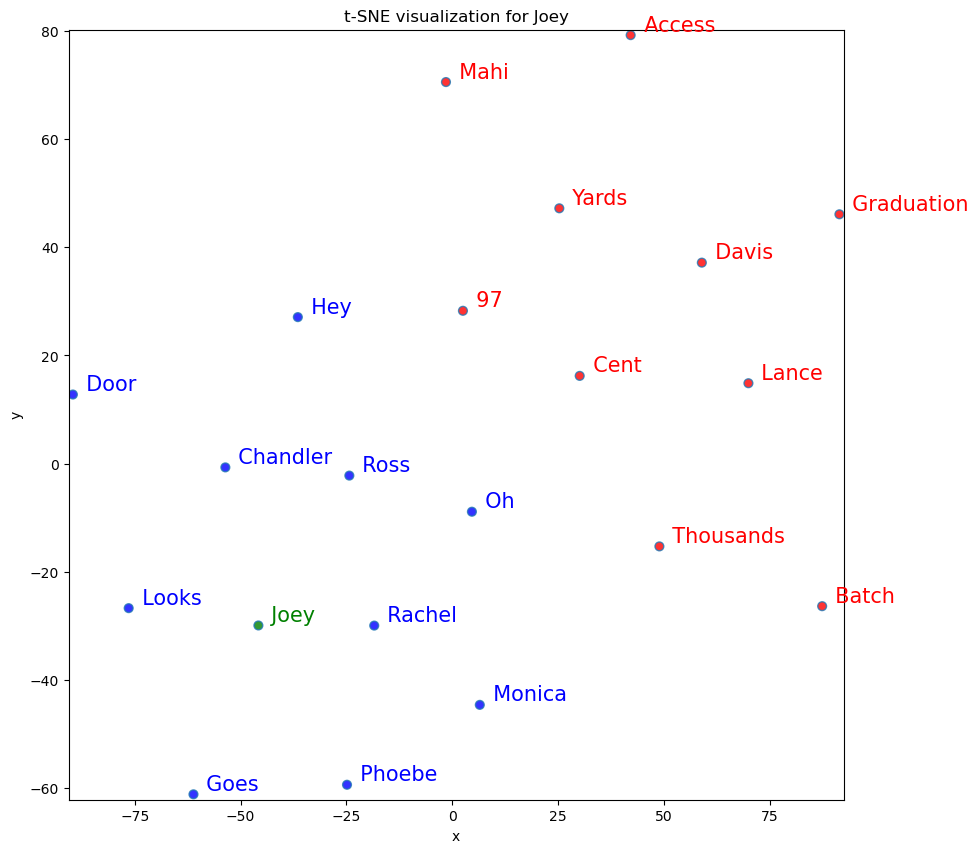

In [ ]:
tsneplot(w2v, 'joey')

## **Task 2: Questions on the Conceptual Level (non-programming) (Grade (2 + 1 + 1 + 4) = 8)**

Please answer the following questions in the notebook cells using markdown. Be precise and short.

### Subtask 1: For gradient descent, what advantage has a decaying learning rate?

Larger learning rates in the beginning of the training supports faster convergence with larger update steps towards the minimum. This can however lead to overshooting and oscillation around the minimum in the later phase of the training. Decaying learning rates leverage the advantage of larger steps in the beginning of the training and at the same time solve the problem of overshooting.

### Subtask 2: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

Maximizing the log-likelihood simplifies the optimization process. It transforms the product of likelihood terms into the sum of log-likelihood terms. As descussed in the lecture, taking the logarithm allows to simplify these products into sums, making it easier to differentiate.

### Subtask 3: Name one advantage that fastText has over Word2Vec?

fastText is capable to capture morphological and semantical information of words, since it represents words as the sum of their character n-gram vectors (subword units). Therefore, handling of out-of-vocabulary words, which is an issue in Word2Vec, is more robust in fastText.

### Subtask 4: Compute the partial derivate of softmax loss for word2vec with respect to the center word vector.

$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[ -log \left( \frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c)} \right)\right] $$
use $U$ to denote the matrix of all embeddings and $y$ for a one-hot vector with a 1 for the true outside word $o$, and $\hat{y}$ for the predicted distribution $P(w|c)$.

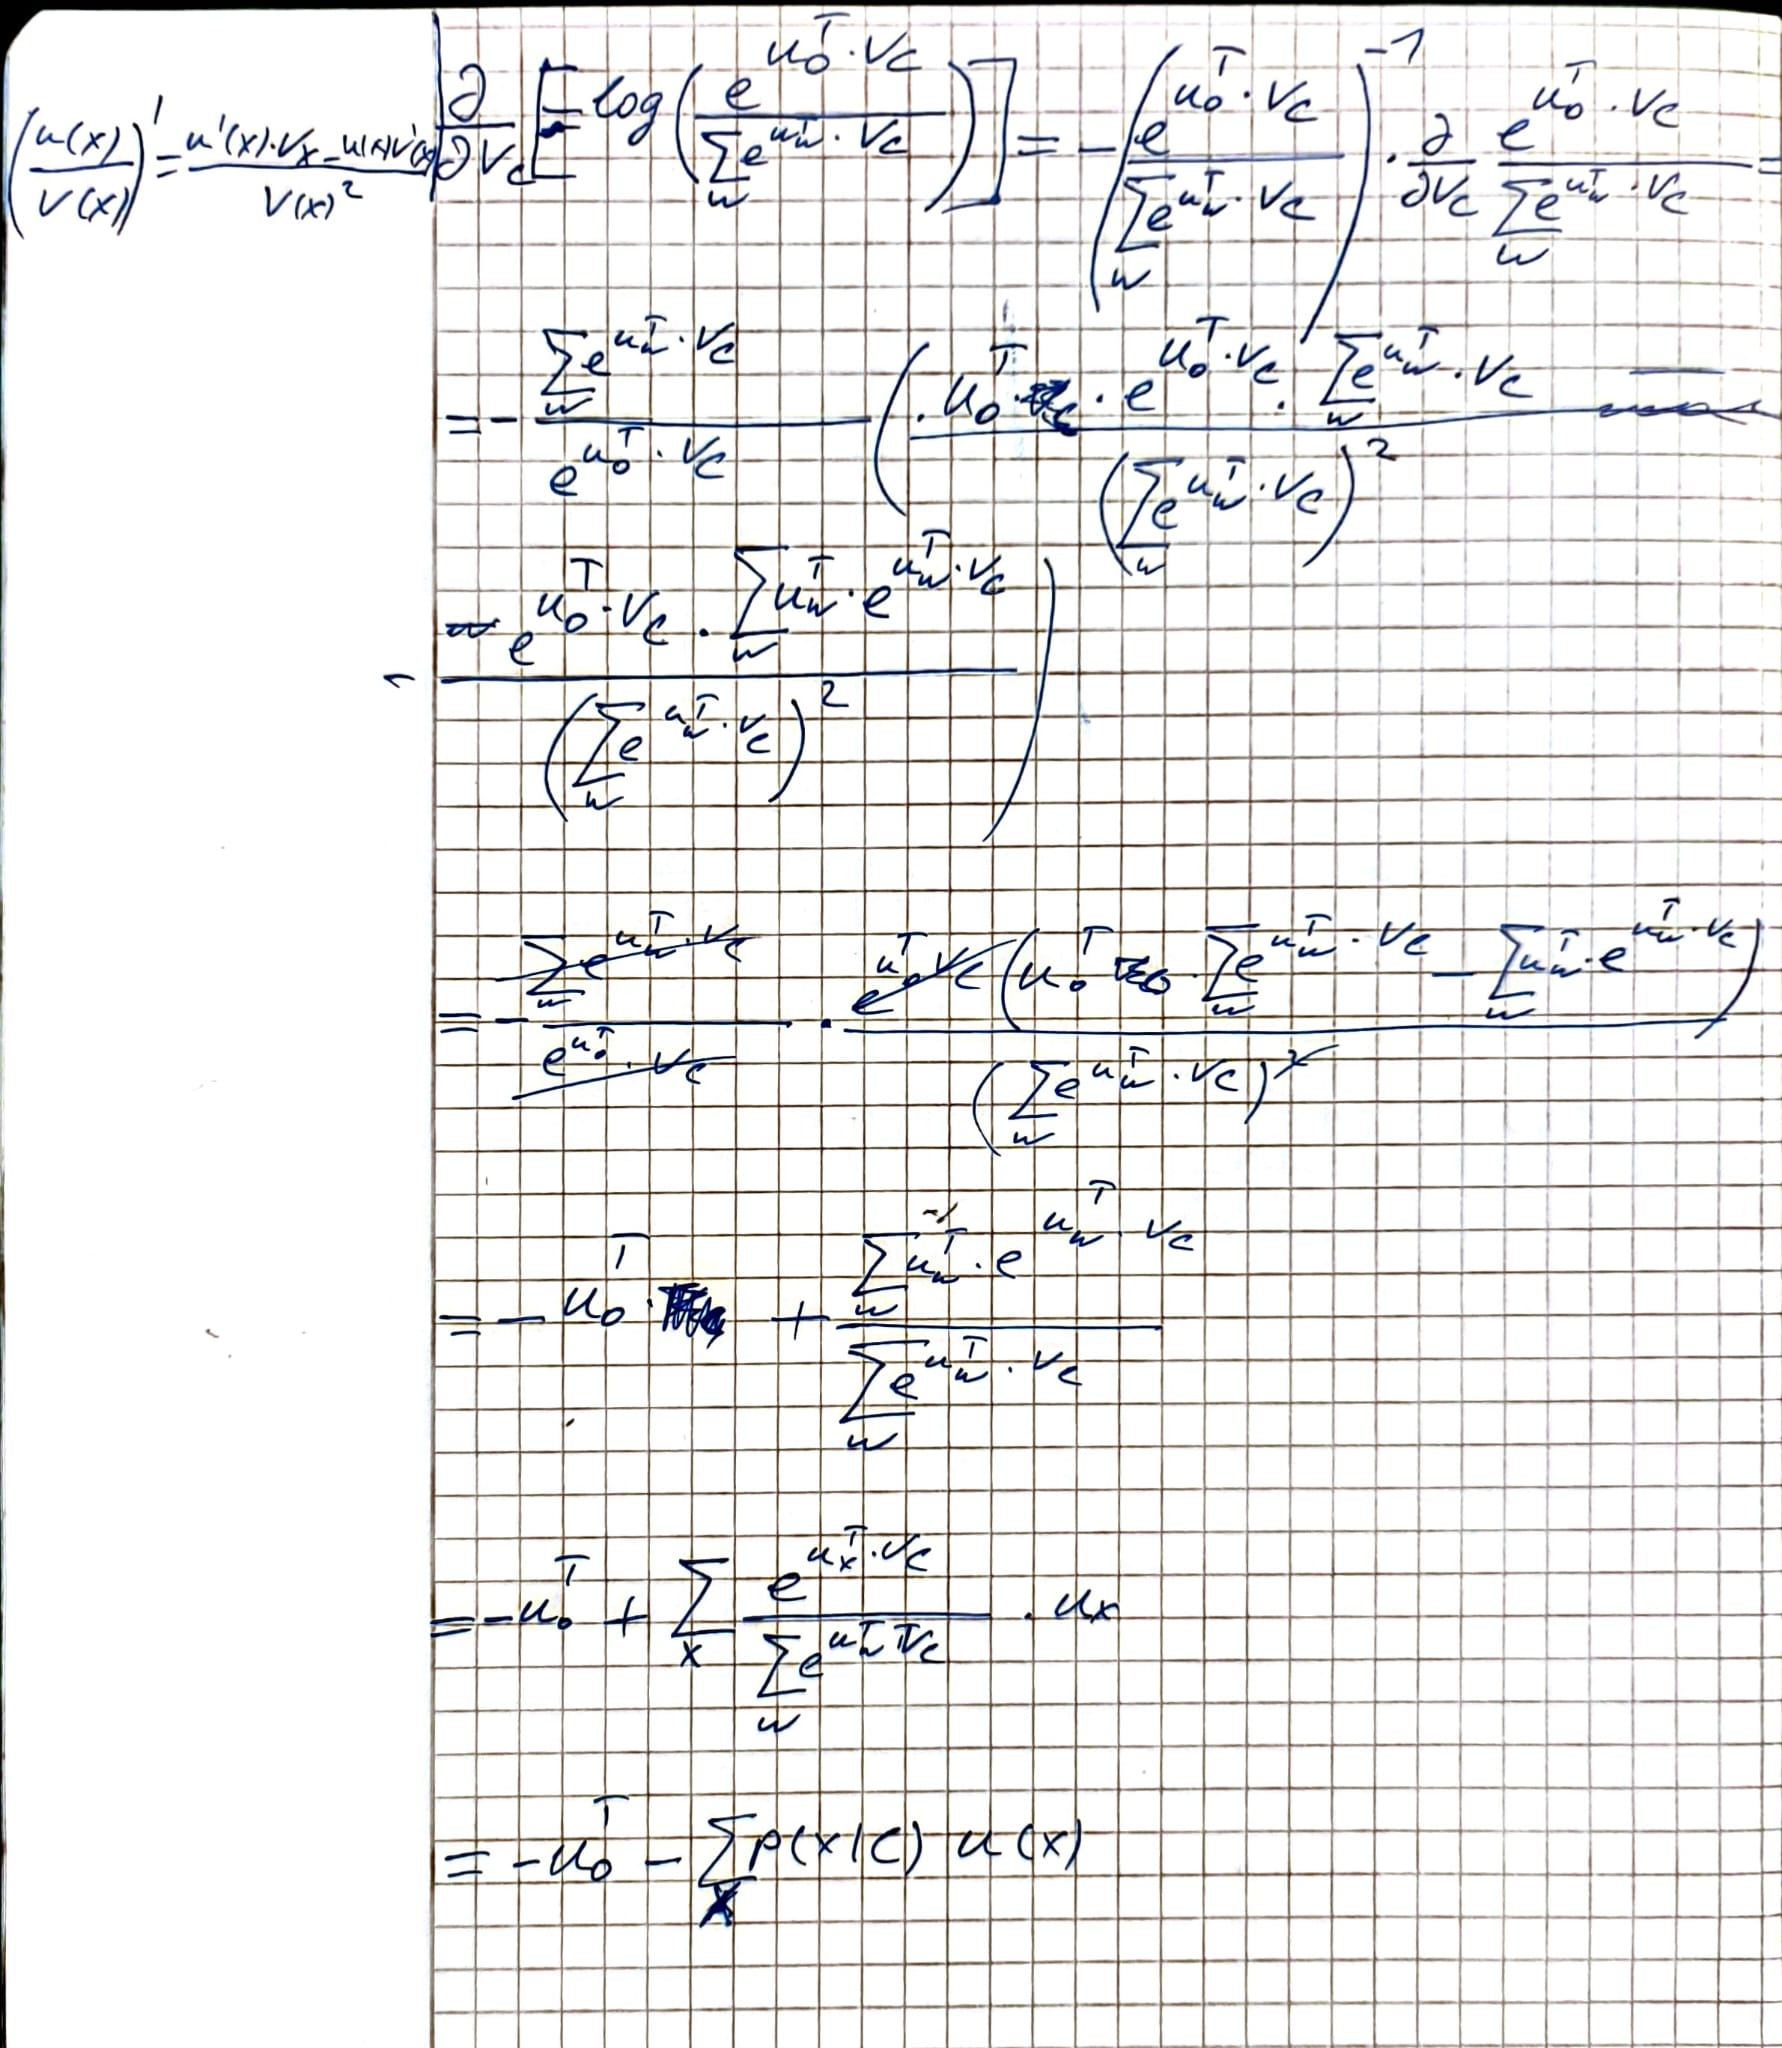

## **Task 3: Auto-Complete Feature (Grade (2 + 6 + 4) = 12)**

Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language model. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word.

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language model by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Subtask 1: Load and Preprocess Data
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where the individual tweets are separated by `\n`

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("./twitter.txt", "r") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.)
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [ ]:
sentences = data.split("\n")
sentences = list(map(lambda s: s.strip(), sentences))
# remove empty string as well
sentences.remove("")

In [ ]:
tokenized_corpus = []# list of list of the tokens in a sentence
for s in sentences:
    doc = nlp(s)
    tokens = [token.text.lower() for token in doc]
    tokenized_corpus.append(tokens)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
from random import Random
Random(4).shuffle(tokenized_corpus)
split = round(len(tokenized_corpus)*0.8)

train = tokenized_corpus[:split]
test = tokenized_corpus[split:]

print(f"overall length: {len(tokenized_corpus)}, train: {len(train)}, test: {len(test)}")

overall length: 47961, train: 38369, test: 9592


In [ ]:
from collections import Counter
flatten_corpus = [item for sublist in train for item in sublist]
word_counts = Counter(flatten_corpus)
vocab = [k for k,v in word_counts.items() if v >= 2]

### keep only the ones with frequency bigger than 2 ###
print(len(vocab)) ### should be 14861 ###
train_replaced = []
test_replaced = []
for sentence in train:
    train_replaced.append([word if word in vocab else "<unk>" for word in sentence])
for sentence in test:
    test_replaced.append([word if word in vocab else "<unk>" for word in sentence])

14861


### Subtask 2: N-gram Based Language Model:
In this section, you will develop an n-grams language model [**1. Large Language Models (LLMs), slide 1-24**]. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word '$w_t$' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will:
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below.

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [ ]:
from collections import defaultdict
def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n

    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram

    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus:
        sentence = [start_token] * n + sentence + [end_token] * n
        # convert list to tuple so it can be used as the key in the dictionary
        sentence = tuple(sentence)

        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count

        for idx in range(0, len(sentence)-(n-1)):
            n_gram = sentence[idx:idx+n]
            n_grams[n_gram] +=1
    return n_grams

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [ ]:
def probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size):
    """
    Estimate the probabilities of the next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary

    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_cnt =  n_gram_cnts[prev_n_gram]
    denominator = (k * vocab_size) + prev_n_gram_cnt
    plus_current_gram =  prev_n_gram + (word,)
    plus_current_gram_cnt = plus_current_gram_cnts[plus_current_gram]
    numerator = k + plus_current_gram_cnt
    prob = numerator / denominator

    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words

    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)

    vocab =  vocab + ["<e>", "<unk>"]
    vocabulary_size = len(vocab)

    probabilities = {}
    for word in vocab:
        prob = probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocabulary_size)
        probabilities[word] = prob
    return probabilities

In [ ]:
# Predict the probability of all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'tonight': 0.05263157894736842,
 'shinnig': 0.05263157894736842,
 'mars': 0.05263157894736842,
 'moon': 0.21052631578947367,
 'stars': 0.05263157894736842,
 'shining': 0.05263157894736842,
 'a': 0.05263157894736842,
 'and': 0.05263157894736842,
 'is': 0.05263157894736842,
 'plants': 0.05263157894736842,
 'plant': 0.05263157894736842,
 'are': 0.05263157894736842,
 'bright': 0.05263157894736842,
 'the': 0.05263157894736842,
 '<e>': 0.05263157894736842,
 '<unk>': 0.05263157894736842}

### Subtask 3: Evaluation

In this part, we use the perplexity score to evaluate your model on the test set. The perplexity score of the test set on an n-gram model is defined as follows:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.
- $W$ is the n-gram

Notice that we have already computed this probability.

The higher the probabilities are, the lower the perplexity will be.

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant

    Returns: Perplexity score for a single sentence
    """

    n =  len(list(n_gram_cnts.keys())[0])
    original_sentence = sentence
    sentence =  ["<s>"] * n + sentence + ["<e>"] * n
    sentence = tuple(sentence)
    N = len(sentence)


    product_pi = 1.0

    ### Compute the product of probabilities ###

    for t in range(n, N):
        n_gram = sentence[t-n:t]# get the n-gram before the predicted word (n-gram before t )
        word =  sentence[t]
        prob = probability(word, n_gram, n_gram_cnts,  plus_current_gram_cnts, vocab_size)
        product_pi *= 1/prob

    perplexity = product_pi**(1/float(N))
    return perplexity

Use `perplexity` function to find the perplexity of a bi-gram model on the first training sample and on the first test sample (first element of the set).

In [ ]:
bigram_counts = n_grams_counts(train_replaced, 2)
trigram_counts = n_grams_counts(train_replaced, 3)

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the perplexity for the train sample should be much lower

Perplexity for first train sample: 85.7743
Perplexity for test sample: 1032.9659


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word

    Returns: (most likely next word,  probability)
    """
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence


    probabs = probabilities(previous_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab)

    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character

    sorted_dict_as_list = sorted(probabs.items(), key=lambda x:x[1],reverse=True)
    if start_with == None:
        # do not return the <unk> symbol if it is the most common one, as it is not helpful at all
        return sorted_dict_as_list[0] if sorted_dict_as_list[0][0] != "<unk>" else sorted_dict_as_list[1]
    else:
        for item in sorted_dict_as_list:
            if item[0].startswith(start_with):
                return item

Test your model based on the bi-gram model created on the training corpus.

In [ ]:
previous_tokens=['i','like']
start_with='b'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('better', 0.00013324450366422385)

In [ ]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('see', 0.0006017249448418801)

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('riley', 0.00020153164046755341)

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with='a'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('allison', 0.00013435442697836894)

## **Task 4: Understanding GloVe (Grade (2 + 4.25 + 4 + 1.75) = 12)**

In this part, you will implement the [GloVe](https://nlp.stanford.edu/projects/glove/) model and train your own word vectors with gradient
descent and numpy. GloVe stands for Global Vectors for word representation, which was developed by researchers at Stanford University to generate word embeddings from corpus statistics.
The statistics of the corpus are represented by a co-occurrence matrix, indicating how often a particular word pair occurs together.
GloVe is based on ratios of probabilities from this co-occurrence matrix, combining the intuitions of count-based models while also being similar to neural models like word2vec.
From this matrix, one can compute the co-occurrence probabilities. We motivate this with an example:

$P_{ik} = P(i,j)$ -> co-occurrence probability or joint probability of words $i$ and $k$

$P_{jk}$ ->co-occurrence probability of words $j$ and $k$

$\frac{P_{ik}}{P_{jk}}$-> corelation between $i$ and $j$ with the prob word $k$

This ratio gives us some insight into the co-relation of the probe word $k$ with the words $i$ and $j$.
An example is shown below for different prob words $k$, where $i$ and $j$ are `ice` and `steam`, respectively.


![glove](https://nlp.stanford.edu/projects/glove/images/table.png)


Image taken from Stanford NLP.

Compared to the raw probabilities, the ratio of probabilities is better able to distinguish relevant words from irrelevant words. Consider the raw probabilities (the first two rows), the values are close to one another and not indicative of the relationships. However, the ratios have more distinct values.

This ratio can be small, large, or equal to 1 depending on the prob word and their co-relation. In the example above, the ratio between ice and steam for `k=solid` is large and for `k=gas` is small, indicating that `solid` is related to ice but `gas` is irrelevant. On the other hand, `water` is not a discriminating element between them, and therefore the ratio is close to one. The same applies to an irrelevant word like `fashion`.

The GloVe model is built on the idea that the "ratio of conditional probabilities represents the word meanings" and a neural model is trained to estimate this conditional probability.

$F(w_i,w_j,\tilde{w_k})=\frac{P_ik}{P_jk}$ -> the right-hand side is computed from the corpus statistics, $w$ is the word vector and $\tilde{w_k}$ is the context vector

The GloVe model embeds the words in a vector space and claims that the difference between them (distinguishing factor) is hidden in the ratio of probabilities. In vector space, the best way to encode this is by vector differences.

$F((w_i-w_j),\tilde{w_k})=\frac{P_ik}{P_jk}$

At this point, the left-hand side is a vector and the right-hand side is a scalar showing the similarity of i and j with the context word k.
For both sides to match and to encode the similarity in the vector space, the left-hand side becomes a dot product.

$F((w_i-w_j)^{T}.\tilde{w_k})=\frac{P_ik}{P_jk}=\frac{F(w_i.\tilde{w_k})}{F(w_j.\tilde{w_k})} $

$F(w_i.\tilde{w_k})=\frac{X_{ik}}{X_{i}}$ -> where $X$ is drived from the co-occurrences matrix

To satisfy a symmetrical relationship (a.k.a. relation(a, b) = relation(b, a)), $F$ is chosen to be an exponential function, $F(x)=exp(x)$. As a result:

$w_i.\tilde{w_k} = log(P_{ik} ) = log(X_{ik} ) − log(X_{i})$

$log(X_{i})$ is independent of $k$ and can be absored into a bias term.

$w_i.\tilde{w_k} = log(P_{ik} ) + b_i +\tilde{b_k} = log(X_{ik} )$

After some weighting and alterations the final cost function, based on the weighted least squares regression model is as follows:

$J= \Sigma^{V}_{i,j=1} f(X_{ij})(w_i.w_j+ b_i +b_j)-log(X_{ik})$

For a detailed overview refer to the original paper: https://nlp.stanford.edu/pubs/glove.pdf
You need to read and understand the GloVe model to solve this exercise.


### Subtask 1: Cost function

Read the paper and describe the following, in your own words:

 1. The intuition behind the weighting schema in the cost function.

 2. How does the objective function of GloVe relate to the objective function of the (word2vec) skip-gram model?

**Answer**
1. The weighting schema can be intuitively described as reducing the influence of extremely frequent words while maintaining the influence of rare words in a given context. Therefore the weighting scheme is based on the context words co-occurences. This is relevant, since extremely frequent words are not neccessarily important to the sentences meaning. The weighting function is a generic alternative to word filtering, which can improve performance for instance word2vec.
2. Both objective functions aim to predict co-occurence probabilities, whereas the GloVe is based on the global co-occurences and word2vec fixed to a local and limited context window.

### Subtask 2: Build Co-occurence matrix


We use the same dataset as the first task and use the `quotes` as the corpus to build the co-occurrences matrix. Similar to the first task we use the `phrases` to transform our input and extract the vocabulary.

In [ ]:
import numpy as np
from scipy import sparse
from math import log
from itertools import chain
from collections import Counter
from tqdm import tqdm
import spacy
import re
import pandas as pd

Complete the function to create dictionaries used for mapping ids to words and words to ids, and a dictionary that counts the number of occurrences of each word. The first two dictionaries are used to map indices in vector space to words and back, and the third dictionary contains the counts of the corpus statistics.

In [ ]:
FRIENDS_PATH = "friends_quotes.csv"

df = pd.read_csv(FRIENDS_PATH)
print(f"Shape of data before filtering: {df.shape}")

# Drop rows with any null values
df = df.dropna()

# Replace empty strings with NaN and then drop those rows
df = df.replace('', float('nan')).dropna()

# Reset the index after dropping rows
df = df.reset_index(drop=True)
print(f"Shape of data after filtering: {df.shape}")

df.head(10)

Shape of data before filtering: (60291, 6)
Shape of data after filtering: (60291, 6)


,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
5,Monica,1.0,Monica Gets A Roommate,"Okay, everybody relax. This is not even a date...",5.0,1.0
6,Chandler,1.0,Monica Gets A Roommate,Sounds like a date to me.,6.0,1.0
7,Chandler,1.0,Monica Gets A Roommate,"Alright, so I'm back in high school, I'm stand...",7.0,1.0
8,All,1.0,Monica Gets A Roommate,"Oh, yeah. Had that dream.",8.0,1.0
9,Chandler,1.0,Monica Gets A Roommate,"Then I look down, and I realize there's a phon...",9.0,1.0


In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def preprocess(doc):
    # Remove stopwords and single characters
    tokens = [token.text for token in doc if token.text not in stopwords and len(token.text) > 1]

    # Use regex to remove non-alphabetic characters
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]

    # Filter None Types
    tokens = [token for token in tokens if token]

    # if len(tokens) > 3:
    return ' '.join(tokens)

# lower qoutes
lowercased_qoutes = df["quote"].str.lower().tolist()

quotes = [preprocess(doc) for doc in nlp.pipe(lowercased_qoutes)]

# none_count = 0
# for quote in quotes:
#     if quote is None:
#         none_count += 1
# print(f"Number of quotes that are None due to less than three tokens: {none_count}")

# Filter None Types
quotes = [quote for quote in quotes if quote]
print(f"Number of quotes after filtering None: {len(quotes)}")

/Users/leonremke/miniconda3/envs/bomberman/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Number of quotes after filtering None: 57196


In [ ]:
#Check if central or perk is included in preprocessed quotes:
central_perk = [line for line in quotes if 'central' in line and 'perk' in line]
print(f"Number of quotes that contain 'central perk': {len(central_perk)}")

Number of quotes that contain 'central perk': 36


In [ ]:
print("First 10 quotes:'\n")
print(quotes[:10])

First 10 quotes:'

['tell guy work', 'cm going guy got ta wrong', 'right joey nice hump hump hairpiece', 'wait eat chalk', 'cause want went carl oh', 'okay everybody relax date people going dinner and having sex', 'sounds like date', 'alright high school standing middle cafeteria realize totally naked', 'oh yeah dream', 'look realize phone']


In [ ]:
from gensim.models.phrases import Phrases

def tokenize(sentence):
    # Basic whitespace tokenizer
    return sentence.split(" ")

def create_vocab(corpus):
    """
    Build a vocabulary containing the frequencies
    corpus: the list of tokenized lines form the corpus

    Returns dictionaries `word` -> (index or unique identified), frequency)`
    and `word` -> (index or unique identified)
    and index or unique identified -> `word`
    and length of the vocab
    """

    word_count_dict = {}  # word id to the number of time it appears
    id_to_word = {}  # mapping ids to words
    word_to_id = {}  # mapping words to ids

    # Tokenize the input corpus into list of words

    # Tokenize the input corpus into list of words
    tokenized_corpus = [tokenize(line) for line in corpus]

    # bigram model
    # Prepare quotes for Phrases
    phrases = Phrases(tokenized_corpus, min_count=10)
    # Check if bigrams worked
    print(f"Number of phrases: {len(phrases.vocab)}")
    # Get a list of all the lines
    lines = list(phrases[tokenized_corpus])

    # flatten the list of lists into a single list of words
    words = [word for sentence in lines for word in sentence]

    # frequency of each word
    word_freq = {}
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

    # Iterate over word_count dict and add words to vocab
    for idx, (word, freq) in enumerate(word_freq.items()):
        # Add word to vocab dictionary
        word_to_id[word] = idx
        # Add word to id_to_word dictionary
        id_to_word[idx] = word
        # Add frequency
        word_count_dict[idx] = freq
    return word_count_dict, id_to_word, word_to_id, len(word_count_dict), lines


In [ ]:
word_count_dict, id_to_word,word_to_id, vocab_size, tokenized_lines =create_vocab(quotes)

INFO - 17:37:35: collecting all words and their counts
INFO - 17:37:35: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:37:35: PROGRESS: at sentence #10000, processed 49206 words and 37154 word types
INFO - 17:37:35: PROGRESS: at sentence #20000, processed 106027 words and 71466 word types
INFO - 17:37:35: PROGRESS: at sentence #30000, processed 161180 words and 99784 word types
INFO - 17:37:35: PROGRESS: at sentence #40000, processed 219155 words and 127559 word types
INFO - 17:37:35: PROGRESS: at sentence #50000, processed 275991 words and 153867 word types
INFO - 17:37:35: collected 171526 token types (unigram + bigrams) from a corpus of 312531 words and 57196 sentences
INFO - 17:37:35: merged Phrases<171526 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 17:37:35: Phrases lifecycle event {'msg': 'built Phrases<171526 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.16s', 'datetime': '2023-11-11T17:37:35.789778', 'gensim'

Number of phrases: 171526


If you have done the exercise correctly, you have `15333` tokens in the vocabulary, and the number of occurrences for `joey` is `1951` and for `central_perk` is `36`

In [ ]:
print("number of occurrences for joey:",word_count_dict[word_to_id['joey']])
print("number of occurrences for central perk:",word_count_dict[word_to_id['central_perk']])
print("vocab size is:",vocab_size)

number of occurrences for joey: 2308
number of occurrences for central perk: 37
vocab size is: 17646


In [ ]:
def calculate_weight(cooccurrences, context_word_ids, center_word_id, side):
    """
    Calculate the weight in the co-occurrence matrix based on the distance of a word
    to the center word
    sentence = [I, went, to , the, bank]
    Let center word be "to" and window size =2
    left_context =[I,went]
    right_context = [the,bank]

    Weights:
    1/distance-> `went` and `the` have weight of 1 and `I` and `bank` have weight of 1/2
    """

    if side == "left_context":
        context_word_ids.reverse()

      ## adjust the weight of the matrix to 1/distance between the center word and context word, where center word will act as the row and the context word is the column##

    for idx, context_word_id in enumerate(context_word_ids):
        distance = abs(idx + 1)
        if distance == 0:
            weight = 1
        weight = 1 / distance
        cooccurrences[center_word_id, context_word_id] += weight

    return cooccurrences



The weight of first to second element on the example matrix should be `1.0`.

In [ ]:
cooccurrences = sparse.lil_matrix((10, 10),dtype=np.float64)
calculate_weight(cooccurrences, [1,3,5], 0, side="right_context")
print("weight of id=0 to id=1 :",cooccurrences[0,1])

weight of id=0 to id=1 : 1.0


We build co-occurrence as a sparse matrix to speed up the computation. The original matrix is a square matrix in the size of the vocabulary. However, many words do not co-occur with one another and we do not need to store those elements.

In [ ]:
def build_cooccur(corpus, window_size=3, min_count=5):
    """
    Create a coocurrance matrix given a corpus
    corpus: the list of tokenized lines form the corpus
    window_size: how many words to right and left to consider

    Returns the co-oocurrance sparse matrix
    """
    vocab, id_to_word,word_to_id, vocab_size, tokenized_lines = create_vocab(corpus)

    #sparse lil_matrix is optimized to operate on matrix which mostly has zeros.
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

    for line in tokenized_lines:
        word_ids = [word_to_id[word] for word in line]

        for i, central_word_id in enumerate(word_ids):

            # left_context_word_ids = [word_ids[j] for j in range(max(i - window_size, 0), i)]
            left_context_word_ids = [word_ids[j] for j in range(max(i - window_size, 0), i)]

            #right side context
            # right_context_word_ids = [word_ids[j] for j in range(i, min(i + window_size, len(word_ids)))]
            # right_context_word_ids = [j for j in range(i + 1, min(i + window_size, len(word_ids)))]
            right_context_word_ids = [word_ids[j] for j in range(i + 1, min(i + window_size + 1, len(word_ids)))]


            ###update the matrix based on the distance weights on both sides###
            # Todo: pass over center_word_id or index? IF newly makes no sence with distances...
            if i > 0:
                cooccurrences = calculate_weight(cooccurrences, left_context_word_ids, central_word_id, side="left_context")
            if i < len(word_ids) - 1:
                cooccurrences = calculate_weight(cooccurrences, right_context_word_ids, central_word_id, side="right_context")

    # go into the LiL-matrix to quickly iterate through all nonzero cells and filter out the ones with minimum count
    cooccurrences_tuples = []
    for i, (row, data) in enumerate(zip(cooccurrences.rows,cooccurrences.data)):
        for j, d in zip(row, data):
            if d >= min_count:
                cooccurrences_tuples.append((i, j, d))

      ## check if the min_count condition is statisfied and then add the elements as the tuple of (i,j,weight)###
    return cooccurrences_tuples


Build a matrix with a window_size of 3 words, and the minimum number of times a word has to occur to be part of the matrix is 10.

In [ ]:
matrix=build_cooccur(quotes, window_size=3, min_count=10)
matrix[103]

INFO - 17:38:35: collecting all words and their counts
INFO - 17:38:35: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:38:35: PROGRESS: at sentence #10000, processed 49206 words and 37154 word types
INFO - 17:38:35: PROGRESS: at sentence #20000, processed 106027 words and 71466 word types
INFO - 17:38:35: PROGRESS: at sentence #30000, processed 161180 words and 99784 word types
INFO - 17:38:35: PROGRESS: at sentence #40000, processed 219155 words and 127559 word types
INFO - 17:38:35: PROGRESS: at sentence #50000, processed 275991 words and 153867 word types
INFO - 17:38:35: collected 171526 token types (unigram + bigrams) from a corpus of 312531 words and 57196 sentences
INFO - 17:38:35: merged Phrases<171526 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 17:38:35: Phrases lifecycle event {'msg': 'built Phrases<171526 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.17s', 'datetime': '2023-11-11T17:38:35.465889', 'gensim'

Number of phrases: 171526


(2, 20, 16.16666666666667)

### Subtask 3: Modelling and Training


We initialize the weights for the context and center words and learn the vectors through backprop, using the GloVe cost function.
Make sure you use the correct weighting schema.

In [ ]:
# Random normal weights intialization
np.random.seed(77)# we set a seed to have similar results
def init_weights(vocab_size, hidden):
     #Each word has a center word vector and a context vector.
     # initilize the correct size vector
    W_center = np.random.randn(vocab_size, hidden)
    # initilize the correct size vector
    b_center = np.random.randn(vocab_size)
    # initilize the correct size vector
    W_context = np.random.randn(vocab_size, hidden)
    # initilize the correct size vector
    b_context = np.random.randn(vocab_size)
    return W_center, b_center, W_context, b_context

keep track of `W_center[0,1]` as it should change based on backprop in the next cells.

In [ ]:
W_center, b_center, W_context, b_context=init_weights(100, 32)
print("check the shapes to make sure the matrices have correct sizes:")
print(W_center.shape)
print(b_center.shape)
print(W_context.shape)
print(b_context.shape)
print("Look at the value of this element and how it changes with back prob:")
print(W_center[0,1])

check the shapes to make sure the matrices have correct sizes:
(100, 32)
(100,)
(100, 32)
(100,)
Look at the value of this element and how it changes with back prob:
0.6615314728168009


Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [ ]:
import math
import sys

def check_nan(update):
    if math.isnan(update) or math.isinf(update):
        sys.stderr.write("\ncaught NaN in update")
        return 0.0
    else:
        return update


In [ ]:
# Back Propagation
def back_prop(W_center, b_center, W_context, b_context, matrix, x_max,  vocab_size, learning_rate, alpha=2):
    """
    W_center, b_center: weight and bias of the center word
    W_context, b_context: weight and bias of the context word
    vocab_size: vocabulary size
    x_max: define our weighting function when computing the cost for two word pairs; see the GloVe paper for more
    details.
    matrix: coocurrance matrix
    alpha: the power of x_max function
    learning_rate: learning rate for gradient descent
    """

    global_cost = 0
    grad_squared_center = np.zeros_like(W_center)
    grad_squared_context = np.zeros_like(W_context)
    grad_squared_bias_center = np.zeros_like(b_center)
    grad_squared_bias_context = np.zeros_like(b_context)

    for i, j, cooccurrence in matrix:
        weight = ((cooccurrence/x_max)**alpha if(cooccurrence < x_max) else 1)
        # Compute inner component of cost function  J' = w_i^Tw_j + b_i + b_j - log(X_{ij})
        # print("weight i transposed:",W_context[j].T, "\n", W_context[j])
        diff_j_prime = np.dot(W_center[i], W_context[j]) + b_center[i] + b_context[j] - np.log(cooccurrence)

        ##Compute cost J = f(X_{ij}) (J')^2##
        cost_j = weight * (diff_j_prime**2)

        # Check for NaN and Infinity values in the diffs
        if np.isnan(diff_j_prime) or np.isinf(diff_j_prime):
            print(f"Encountered NaN/Infinity value in diff_j_prime, setting to 0.")
            continue

        global_cost += cost_j
        ##Compute gradients for word vectors##
        grad_center = diff_j_prime * W_context[j]
        grad_context = diff_j_prime * W_center[i]

        ##Compute gradients for bias terms##
        grad_bias_center = diff_j_prime
        grad_bias_context = diff_j_prime

        # Accumulate squared gradients
        grad_squared_center[i] += grad_center ** 2
        grad_squared_context[j] += grad_context ** 2
        grad_squared_bias_center[i] += grad_bias_center ** 2
        grad_squared_bias_context[j] += grad_bias_context ** 2

        # Update weights with adaptive learning rates
        W_center[i] -= learning_rate * grad_center / np.sqrt(grad_squared_center[i] + 1e-8)
        W_context[j] -= learning_rate * grad_context / np.sqrt(grad_squared_context[j] + 1e-8)
        b_center[i] -= learning_rate * grad_bias_center / np.sqrt(grad_squared_bias_center[i] + 1e-8)
        b_context[j] -= learning_rate * grad_bias_context / np.sqrt(grad_squared_bias_context[j] + 1e-8)
    return W_center, b_center, W_context, b_context, global_cost

Based on the random seed, the value of `W_center[0,1]` should have changed due to backpropagation.


In [ ]:
test_matrix=[(0,1,1),(0,2,0.4),(0,3,0.9),(0,4,0.4)]
W_center, b_center, W_context, b_context, global_cost  =back_prop(W_center, b_center, W_context, b_context, test_matrix, x_max=10,  vocab_size=100, learning_rate=0.01)
print("cost:",global_cost)
print("changed value:")
print(W_center[0,1])

cost: 0.20163369439311515
changed value:
0.674624772684653



Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [ ]:
def train_GloVe(matrix, vocab_size, epochs = 10, learning_rate = 0.0001, x_max = 10, hidden_dim=100):
    """
    Train the glove model based the co-ocurrance matrix for a number of epochs
    matrix: co-occcurance matrix
    vocab_size: number of words in vocab
    epochs: number of passes through the data
    learning_rate: learning rate for back prop
    x_max: parameter of the weighting function
    hidden_dim: dimension of the vectors
    """
    W_center, b_center, W_context, b_context = init_weights(vocab_size, hidden_dim)
    for i in tqdm(range(epochs)):
        ### perform backprop###
        W_center, b_center, W_context, b_context, global_cost = back_prop(W_center, b_center, W_context, b_context, matrix, x_max,  vocab_size, learning_rate, alpha=0.75)
         # Only print on last epoch:
        if i == epochs - 1:
            print(f"Cost at epoch {i}: {global_cost:.4f}")
    return W_center, W_context

Train the model with hidden dimension of `100` and learning rate of `0.001` for a `100` epochs.

In [ ]:
## your code ##
W_center, W_context = train_GloVe(matrix, vocab_size, epochs = 100, learning_rate = 0.001, x_max = 10, hidden_dim=100)

100%|██████████| 100/100 [00:06<00:00, 15.49it/s]

Cost at epoch 99: 124658.8666


As you can see by looking at the loss, the model still needs more time to converge to a minimum.
However, we keep the training short and keeping in mind that the vectors can improve we look at some examples.
Take the average, transpose, and normalize the matrix.

In [ ]:
from numpy.linalg import norm
# take the average of the learned vector as the final vector
W = np.add(W_center, W_context)/2
W = W.T
W = W/norm(W)

In [ ]:
W.shape

(100, 17646)

Lets create a dictionary that points from a word to its vector.

In [ ]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_id.keys():
    word_to_vector[word] = W[:, word_to_id[word]]

### Subtask 4: Compare to Skip-gram


Let's compute the similarities for the same words in Task 1 to compare the results with word2vec. This time you need to implement the similarity function, based on the dot product. To get to the topk you need to sort the elements based on their similarity.



In [ ]:
from numpy import dot

def most_similar(word_vector,all_vectors,id_to_word, topk):
    """
    function to find the topk most similar words to a word vector
    word_vector: vector of the search word
    all_vectors: all word vectors
    id_to_word: dictionary from id to words
    topk: number of elements to return
    """
    # Use cosine similarity to find the most similar words
    cosine_sim = dot(word_vector, all_vectors)
    most_similar_ids = np.argsort(cosine_sim)
    # Save cosine sim with assigned word to file by using most_similar_ids
    most_similar_words = [id_to_word[idx] for idx in most_similar_ids]
    most_similar_cosine_sim = [cosine_sim[idx] for idx in most_similar_ids]

    # Combine words and cosine sim into a list of tuples
    most_similar_words = list(zip(most_similar_words, most_similar_cosine_sim))
    inverted_most_similar_words = most_similar_words[::-1]
    # Return the top k most similar words
    return inverted_most_similar_words[:topk]

In [ ]:
glove_most_sim = most_similar(word_to_vector["central_perk"],W,id_to_word,5)
w2v_most_sim = w2v.wv.most_similar(positive=["central_perk"])
print("most similar words to central_perk using glove:",glove_most_sim)
print("most similar words to central_perk using word2vec:",w2v_most_sim)

most similar words to central_perk using glove: [('central_perk', 4.9774351825349305e-05), ('stability', 2.1907821515094245e-05), ('hideous', 2.0272584095650243e-05), ('loser', 2.023115948265727e-05), ('journal', 1.9030134049404998e-05)]
most similar words to central_perk using word2vec: [('back', 0.7201736569404602), ('conan', 0.616219699382782), ('sitting_couch', 0.4656095802783966), ('ish', 0.45086634159088135), ('cuddling', 0.44639337062835693), ('intrigued', 0.43748244643211365), ('crossword', 0.42760711908340454), ('crash', 0.42212584614753723), ('appartment', 0.41930893063545227), ('shhh', 0.41291123628616333)]


In [ ]:
glove_most_sim = most_similar(word_to_vector["joey"],W,id_to_word,5)
w2v_most_sim = w2v.wv.most_similar(positive=["joey"])
print("most similar words to joey using glove:",glove_most_sim)
print("most similar words to joey using word2vec:",w2v_most_sim)

most similar words to joey using glove: [('joey', 4.972325388737588e-05), ('tingle', 2.0903335218143848e-05), ('pees', 2.0674301089527424e-05), ('godeh', 1.969455591098164e-05), ('crossing', 1.9310725582351038e-05)]
most similar words to joey using word2vec: [('chandler', 0.7492083311080933), ('ross', 0.6886774301528931), ('monica', 0.6481075286865234), ('rachel', 0.6369766592979431), ('phoebe', 0.6366932988166809), ('goes', 0.5658732056617737), ('hey', 0.520183265209198), ('oh', 0.5040765404701233), ('looks', 0.5030487179756165), ('door', 0.4982396066188812)]


Compute the similarity between the `('rachel', 'mrs_green')`, `('smelly_cat', 'song')` and `('ross', 'spaceship')`.

In [ ]:
def pairwise_sim(word1, word2, word_to_vector):
    """
    function to find the similarity between two words
    word1, word2: the two words
    word_to_vector: dictionary from word to vector
    """
    ### find the similarity between two words ##
    # Use cosine similarity to find the most similar words
    cosine_sim = dot(word_to_vector[word1], word_to_vector[word2])
    return cosine_sim

In [ ]:
w2v.wv.similarity("mrs_green", 'rachel')

0.4365295

In [ ]:
## your code ##
pairwise_sim("rachel", "mrs_green", word_to_vector)

1.172752475994363e-05

In [ ]:
w2v.wv.similarity("smelly_cat", 'song')

0.47669905

In [ ]:
## your code ##
pairwise_sim('smelly_cat', 'song', word_to_vector)

-3.777437328050534e-06

In [ ]:
w2v.wv.similarity("ross", 'spaceship')

-0.20768374

In [ ]:
## your code ##
pairwise_sim('ross', 'spaceship', word_to_vector)

4.106331097953352e-06

If you see your results are not as meaningful as the gensim model, do not be discouraged. With better optimization and longer training the results should improve. If you have time play around a bit more with your model and see if you can generate more meaningful vectors.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2995dafc-2409-4d4e-859d-95843714f594' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>